In [90]:
# import libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from translate import Translator
import seaborn as sns
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [3]:
root_path = "C:\\Users\\Solar\\Furiends\\Furiends\\data\\raw\\Fake Data2"

In [4]:
# View all the files in the data folder; 
os.listdir(root_path)

['bigT.sql',
 'bigT2.csv',
 'bigT3.csv',
 'data_with_satisfication.csv',
 'freq&dura per user per act_category.sql',
 'frequency&duration_activity.csv',
 'fulldb-09-03-2023-23-04-beta.sql',
 'whole11.csv']

## Data Loading

In [13]:
data = pd.read_csv(os.path.join(root_path, 'data_with_satisfication.csv')).drop(["Unnamed: 0"], axis=1)
data

,User_id,First_Name,Last_Name,Address,Age,Gender,Rehabilitation,Pet_intimacy,category_name,Pet_Name,log_count,com_count,avg_loading,sum_duration,User_satisfication
0,1,Jane,Bruen,5272 Adela Overpass Suite 982\r\nRozellacheste...,28,1,2,0.42,'Maltese',Barney,0.333333,0.333333,0.526948,0.268787,3.522098
1,2,Eliseo,Trantow,"2506 Mertz Inlet\r\nSouth Ezekielshire, OK 56215",12,1,1,0.12,'Golden Retriever',Juliana,0.000000,0.083333,1.000000,0.003579,3.717647
2,3,Oceane,Walter,"9469 Frank Orchard Apt. 685\r\nLake Irmastad, ...",64,1,2,0.91,'Bulldog',Sabrina,0.500000,0.166667,0.526618,0.225447,4.005074
3,4,Zack,Marvin,"982 Susan Manors\r\nPort Amiya, UT 97043-2723",38,1,1,0.86,'German Shepherd',Yasmine,0.666667,0.583333,0.550415,0.831412,9.152728
4,5,Marco,Kessler,"671 Troy Isle Suite 459\r\nNew Carriemouth, OK...",28,1,1,0.19,'German Shepherd',Cristopher,0.250000,0.500000,0.821139,0.045328,4.692451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,Ethan,Schuppe,"17224 Koelpin Rest\r\nTheresiashire, GA 69914",79,2,1,0.82,'Bulldog',Filomena,0.250000,0.333333,0.396222,0.306561,5.775798
596,597,Austin,Legros,"476 Veda View\r\nGroverfurt, AK 15766-2282",80,1,2,0.91,'Shi-ba-inu',Herta,0.166667,0.500000,0.425255,0.201590,3.474951
597,598,Ilene,Dietrich,"934 Josianne Inlet\r\nLavonnechester, AZ 30057...",74,1,2,0.28,'Poodle',Lamont,0.083333,0.333333,0.215269,0.004374,1.512764
598,599,Novella,Becker,"76281 Germaine Valley\r\nBoscobury, DE 99069-3814",29,2,2,0.10,'Golden Retriever',Wendy,0.500000,0.166667,0.427905,0.757455,5.224393


In [14]:
data["User_satisfication"].describe()

count    596.000000
mean       4.782320
std        1.405241
min        1.302399
25%        3.783285
50%        4.849050
75%        5.718694
max        9.152728
Name: User_satisfication, dtype: float64

In [57]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

avg_loading
sum_duration
User_satisfication


In [61]:
data = data.dropna()

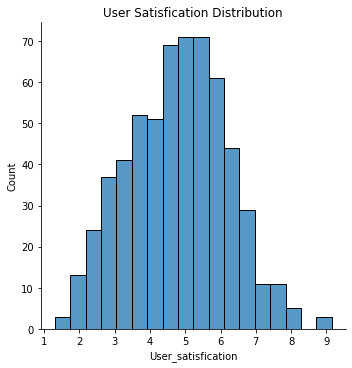

In [62]:
sns.displot(data, x="User_satisfication").set(title="User Satisfication Distribution")

In [63]:
data.shape

(596, 15)

In [64]:
X = data[["Age", "Gender", "Rehabilitation", "Pet_intimacy", "log_count", "com_count", "avg_loading", "sum_duration"]].values
Y = data[["User_satisfication"]].values

In [75]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_normal = preprocessing.normalize(X_scale)
X_normal

array([[0.15350304, 0.        , 0.74832732, ..., 0.24944244, 0.39432989,
        0.20114086],
       [0.        , 0.        , 0.        , ..., 0.0825405 , 0.99048605,
        0.00354448],
       [0.39305406, 0.        , 0.58958109, ..., 0.09826351, 0.310484  ,
        0.13291947],
       ...,
       [0.58117198, 0.        , 0.73115185, ..., 0.24371728, 0.15739443,
        0.00319788],
       [0.12397897, 0.56884468, 0.56884468, ..., 0.09480745, 0.2434115 ,
        0.4308744 ],
       [0.11637483, 0.        , 0.69824896, ..., 0.23274965, 0.2641602 ,
        0.20239503]])

In [77]:
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X_normal, Y, test_size=0.3)

In [78]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.5)

In [79]:
print("Train size: ", X_train.shape[0], "\nValidation size: ", X_val.shape[0], "\nTest size: ", X_test.shape[0])

Train size:  417 
Validation size:  89 
Test size:  90


In [109]:
# There are 8 columns in the X data, meaning we are using 8 features to make predictions
# We would build a neural network with two hidden layers of size 32 and output a single predicted value of y(the satisfication level)
# website to draw nn archetecture: http://alexlenail.me/NN-SVG/index.html
nn_model = Sequential([
    Dense(32, activation="relu", input_shape=(8,)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid"),
])
nn_model.compile(optimizer='sgd',
                loss="mse",
                metrics=['mean_squared_error'])
Y_pred = nn_model.fit(X_train, Y_train, batch_size=70, epochs=150, validation_data=(X_val, Y_val))

Epoch 1/150
6/6 [==============================] - 0s 25ms/step - loss: 20.2260 - mean_squared_error: 20.2260 - val_loss: 20.9441 - val_mean_squared_error: 20.9441
Epoch 2/150
6/6 [==============================] - 0s 5ms/step - loss: 19.6321 - mean_squared_error: 19.6321 - val_loss: 20.3798 - val_mean_squared_error: 20.3798
Epoch 3/150
6/6 [==============================] - 0s 5ms/step - loss: 19.1054 - mean_squared_error: 19.1054 - val_loss: 19.8634 - val_mean_squared_error: 19.8634
Epoch 4/150
6/6 [==============================] - 0s 5ms/step - loss: 18.6115 - mean_squared_error: 18.6115 - val_loss: 19.3651 - val_mean_squared_error: 19.3651
Epoch 5/150
6/6 [==============================] - 0s 6ms/step - loss: 18.1317 - mean_squared_error: 18.1317 - val_loss: 18.8857 - val_mean_squared_error: 18.8857
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 17.6830 - mean_squared_error: 17.6830 - val_loss: 18.4583 - val_mean_squared_error: 18.4583
Epoch 7/150
6/6 [====

6/6 [==============================] - 0s 4ms/step - loss: 16.1302 - mean_squared_error: 16.1302 - val_loss: 17.1090 - val_mean_squared_error: 17.1090
Epoch 52/150
6/6 [==============================] - 0s 4ms/step - loss: 16.1297 - mean_squared_error: 16.1297 - val_loss: 17.1084 - val_mean_squared_error: 17.1084
Epoch 53/150
6/6 [==============================] - 0s 6ms/step - loss: 16.1292 - mean_squared_error: 16.1292 - val_loss: 17.1080 - val_mean_squared_error: 17.1080
Epoch 54/150
6/6 [==============================] - 0s 6ms/step - loss: 16.1287 - mean_squared_error: 16.1287 - val_loss: 17.1075 - val_mean_squared_error: 17.1075
Epoch 55/150
6/6 [==============================] - 0s 5ms/step - loss: 16.1283 - mean_squared_error: 16.1283 - val_loss: 17.1071 - val_mean_squared_error: 17.1071
Epoch 56/150
6/6 [==============================] - 0s 5ms/step - loss: 16.1279 - mean_squared_error: 16.1279 - val_loss: 17.1066 - val_mean_squared_error: 17.1066
Epoch 57/150
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 16.1193 - mean_squared_error: 16.1193 - val_loss: 17.0981 - val_mean_squared_error: 17.0981
Epoch 102/150
6/6 [==============================] - 0s 5ms/step - loss: 16.1192 - mean_squared_error: 16.1192 - val_loss: 17.0980 - val_mean_squared_error: 17.0980
Epoch 103/150
6/6 [==============================] - 0s 4ms/step - loss: 16.1192 - mean_squared_error: 16.1192 - val_loss: 17.0979 - val_mean_squared_error: 17.0979
Epoch 104/150
6/6 [==============================] - 0s 6ms/step - loss: 16.1191 - mean_squared_error: 16.1191 - val_loss: 17.0978 - val_mean_squared_error: 17.0978
Epoch 105/150
6/6 [==============================] - 0s 6ms/step - loss: 16.1190 - mean_squared_error: 16.1190 - val_loss: 17.0977 - val_mean_squared_error: 17.0977
Epoch 106/150
6/6 [==============================] - 0s 5ms/step - loss: 16.1189 - mean_squared_error: 16.1189 - val_loss: 17.0976 - val_mean_squared_error: 17.0976
Epoch 107/150
6/6 [=====

In [110]:
score = nn_model.evaluate(X_test, Y_test, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 16.2356 - mean_squared_error: 16.2356


# == Above are the code for Neural Network, below were previously wrote ==

In [ ]:
# Neural Network
class NN():
    def __init__(self, input_n, layers=[256,128], output_n, lr, iterations):
        self.input_layer = input_n
        self.output_layer = output_n
        self.fc1 = nn.Linear(self.input_layer, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], self.output_layer)

        self.lr = lr
        self.iterations = iterations
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class NN_train_test():
    def __init__(self, input_n, layers, output_n, lr， iterations, num_epochs):
        self.model = NN(input_n=input_n, layers=layers, output_n=output_n, lr=lr, iterations=iterations)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)
        self.num_epochs = num_epochs
    def train(X, y):
        for epoch in range(self.num_epochs):
            correct = 0
            l = 0
            for i in range(X.shape[0]):
                data = X.iloc[i, :]
                result = y.iloc[i, :]
                prediction = self.model(data)
                loss = self.criterion(prediction, result)
                loss.backward()
                optimizer.step()

                _, predictions = prediction.max(dim=1)
                correct += torch.eq(predictions, result).sum().item()
                l += result.shape[0]
            accuracy = correct / l
            print("Epoch: {}, Accuracy: {}".format(epoch, accuracy))

    def test(X, y):
        pass

In [ ]:
# Logistic Model
input = data.loc[:, 'Have diseases':"Recovery"]
target = data[["Recovery"]]

X, y = input, target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [ ]:
iterations_n = 1000
learning_rate = 0.01
num_feature = len(cols)

In [ ]:
class PytorchLRModel(nn.Module):
    def __init__(self, num_feature):
        super(PytorchLRModel, self).__init__()
        self.fc1 = nn.Linear(num_feature, 2)
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x[:,1]

clf = PytorchLRModel(num_feature)
criterion = nn.BCELoss()

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(clf.parameters(), lr=learning_rate)
input = Variable(torch.Tensor(X_train.values))
target = Variable(torch.Tensor(y_train.values)).long()

clf.train()
for iter_ in range(iterations_n):
  optimizer.zero_grad()
  scores = clf(input)
  loss = criterion(scores.unsqueeze(1), target.float())
  loss.backward()
  optimizer.step()

  if iter_ % 100 == 0:
    print('Iteration {}, Loss: {}'.format(iter_, loss.data.cpu().numpy()))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration 0, Loss: 52.380950927734375
Iteration 100, Loss: 52.380950927734375
Iteration 200, Loss: 52.380950927734375
Iteration 300, Loss: 52.380950927734375
Iteration 400, Loss: 52.380950927734375
Iteration 500, Loss: 52.380950927734375
Iteration 600, Loss: 52.380950927734375
Iteration 700, Loss: 52.380950927734375
Iteration 800, Loss: 52.380950927734375
Iteration 900, Loss: 52.380950927734375


In [ ]:
clf.eval()
target = Variable(torch.Tensor(y_test.values)).long()
y_hat = clf(Variable(torch.Tensor(X_test.values)))
predictions = (y_hat >= 0.5).float()
print(predictions)
print(target.shape)
accuracy = torch.eq(predictions, target).sum().item() / target.size()[0]
print("Accuracy: ", accuracy)

tensor([0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([8, 1])
Accuracy:  5.0


In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 8, random_state = 18).fit(X_train, y_train)
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)

0.058571500000000006
0.2420154953716807


In [ ]:
# Neural Network
class NN():
    def __init__(self, input_n, layers=[256,128], output_n, lr, iterations):
        self.input_layer = input_n
        self.output_layer = output_n
        self.fc1 = nn.Linear(self.input_layer, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], self.output_layer)

        self.lr = lr
        self.iterations = iterations
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class NN_train_test():
    def __init__(self, input_n, layers, output_n, lr， iterations, num_epochs):
        self.model = NN(input_n=input_n, layers=layers, output_n=output_n, lr=lr, iterations=iterations)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(),lr=lr)
        self.num_epochs = num_epochs
    def train(X, y):
        for epoch in range(self.num_epochs):
            correct = 0
            l = 0
            for i in range(X.shape[0]):
                data = X.iloc[i, :]
                result = y.iloc[i, :]
                prediction = self.model(data)
                loss = self.criterion(prediction, result)
                loss.backward()
                optimizer.step()

                _, predictions = prediction.max(dim=1)
                correct += torch.eq(predictions, result).sum().item()
                l += result.shape[0]
            accuracy = correct / l
            print("Epoch: {}, Accuracy: {}".format(epoch, accuracy))

    def test(X, y):
        pass

In [ ]:
# RNN
